# Softmax exercise

We will implement a softmax classifier that is trained on the CIFAR10 dataset. The output is a model that is able to classify the input image into the 10 different classes of the CIFAR10 dataset.

Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- use a validation set to **tune the learning rate** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import time
import pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../data/cifar-10-batches-py'
    X_train, y_train = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Files already downloaded and verified
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)


## Softmax Classifier

Your code for this section will all be written inside **softmax.py**. This is where the method **softmax_loss_vectorized** will be implemented. This method just returns the loss and gradient after applying the softmax function.


In [3]:
from softmax import softmax_loss_vectorized
W = np.random.randn(3073, 10) * 0.0001
reg=1
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_val, y_val,reg)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

vectorized loss: 2.447536e+00 computed in 0.024990s


## In the file linear_classifier.py, implement SGD in the function LinearClassifier.train() and call this function to do the training.
## Write the LinearSVM.predict() function and call this function to evaluate the performance on both the training and validation set

In [4]:
# Use the validation set to tune hyperparameters (learning rate). 
# You should experiment with different ranges for the learning
# rates; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from linear_classifier import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [6.3e-6, 6.5e-6]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning.                                  #
# Save the best trained softmax classifer in best_softmax.                     #
################################################################################

num_splt_lr = 10
for i in range(num_splt_lr):
        print(i)
        learning_rate_i = learning_rates[0] + i * (learning_rates[1] - learning_rates[0]) / num_splt_lr
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rate_i,
                              num_iters=15000, verbose=False)

        y_train_pred = softmax.predict(X_train)
        
        accuracy_train = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        accuracy_val = np.mean(y_val == y_val_pred)

        results[learning_rate_i] = (accuracy_train, accuracy_val)

        if accuracy_val > best_val:
            best_val = accuracy_val
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr in sorted(results):
    train_accuracy, val_accuracy = results[lr]
    print('lr %e train accuracy: %f val accuracy: %f' % (
                lr, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

0
1
2
3
4
5
6
7
8
9
lr 6.300000e-06 train accuracy: 0.418796 val accuracy: 0.339000
lr 6.320000e-06 train accuracy: 0.416469 val accuracy: 0.345000
lr 6.340000e-06 train accuracy: 0.418347 val accuracy: 0.345000
lr 6.360000e-06 train accuracy: 0.429837 val accuracy: 0.347000
lr 6.380000e-06 train accuracy: 0.377122 val accuracy: 0.347000
lr 6.400000e-06 train accuracy: 0.414408 val accuracy: 0.349000
lr 6.420000e-06 train accuracy: 0.423878 val accuracy: 0.357000
lr 6.440000e-06 train accuracy: 0.415673 val accuracy: 0.348000
lr 6.460000e-06 train accuracy: 0.389041 val accuracy: 0.324000
lr 6.480000e-06 train accuracy: 0.431327 val accuracy: 0.368000
best validation accuracy achieved during cross-validation: 0.368000


In [5]:
# evaluate on val set
# Evaluate the best softmax on val set
y_val_pred = best_softmax.predict(X_val)
print(y_val_pred)
val_accuracy = np.mean(y_val == y_val_pred)
print('softmax on raw pixels final test set accuracy: %f' % (val_accuracy, ))

[8 2 8 3 6 6 0 8 4 0 7 9 9 8 7 3 4 3 8 7 8 1 1 1 2 8 8 6 0 9 6 1 5 5 5 9 2
 7 7 5 8 6 8 8 6 1 6 7 7 4 1 2 3 4 8 4 6 9 7 3 8 7 6 7 7 9 1 8 7 4 4 7 8 1
 7 9 7 6 7 0 6 2 8 3 1 8 8 8 2 2 0 4 0 5 6 6 8 4 8 2 0 2 8 7 5 5 2 0 0 2 6
 1 9 6 7 9 5 6 5 6 5 4 1 9 0 8 6 9 8 5 0 6 9 8 8 6 6 8 3 7 4 4 3 3 2 5 4 1
 9 0 1 8 8 8 7 8 6 2 8 2 8 8 7 3 8 1 8 8 7 0 7 5 5 9 8 0 0 8 8 3 8 5 8 7 8
 2 1 4 3 2 7 8 5 8 8 8 8 7 4 7 6 8 9 7 1 0 6 4 9 6 5 6 9 6 6 5 3 8 2 8 8 1
 2 0 4 9 4 5 1 5 9 4 3 2 1 8 0 5 0 1 0 7 4 4 1 8 8 8 4 7 8 4 2 8 9 8 4 8 0
 5 9 6 7 5 7 7 8 5 8 1 1 5 7 8 5 2 0 6 1 8 9 7 6 1 8 6 7 6 5 4 2 8 6 5 6 7
 8 2 5 8 5 2 7 0 5 4 2 3 8 4 8 2 4 1 6 4 4 4 6 7 4 1 8 7 5 2 7 3 2 1 8 7 7
 5 6 5 8 1 0 2 8 7 5 5 8 9 8 0 1 0 1 3 5 7 7 6 5 0 8 1 1 8 9 7 6 9 1 8 7 9
 1 8 8 8 9 0 8 5 6 8 3 1 6 1 2 0 3 9 8 8 7 6 5 8 6 8 7 7 2 6 8 8 6 6 4 9 4
 2 2 1 6 1 4 7 4 8 8 9 7 5 0 6 8 0 9 9 8 8 5 8 8 6 0 6 9 1 1 5 1 0 6 8 8 3
 5 8 8 5 6 1 4 7 5 7 4 6 6 8 4 6 6 1 3 3 3 8 2 2 5 1 3 2 0 7 8 4 4 8 5 8 6
 7 7 1 5 6 1 4 4 8 8 1 7 

Save the best_softmax weights using pickle:

In [6]:
with open('softmax_weights.pkl', 'wb') as f:
    pickle.dump(best_softmax.W, f)

Load the best_softmax weights using pickle:

In [7]:
with open('softmax_weights.pkl', 'rb') as f:
    W = pickle.load(f)
new_softmax = Softmax()
new_softmax.W = W.copy()

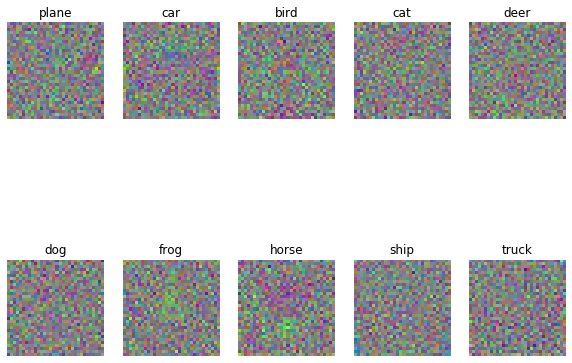

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])